In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize

In [6]:
mnist_train = DataLoader(datasets.MNIST(
    '/files/',
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])),
    batch_size=64,
    shuffle=True)
mnist_test = DataLoader(datasets.MNIST(
    '/files/',
    train=False,
    download=True,
    transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])),
    batch_size=64,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [7]:
examples = enumerate(mnist_test)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([64, 1, 28, 28])

Label: tensor(9)


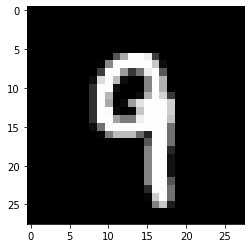

In [10]:
plt.imshow(example_data[6][0], cmap='gray')
print("Label:", example_targets[6])

In [11]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

In [12]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [13]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(mnist_train.dataset) for i in range(10)] # 10 is the number of epochs

In [18]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(mnist_train):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(mnist_train.dataset),
          100. * batch_idx / len(mnist_train), loss.item()
      ))
      train_losses.append(loss.item())
      train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(mnist_train.dataset)))
      torch.save(model.state_dict(), '/files/model.pth')
      torch.save(optimizer.state_dict(), '/files/optimizer.pth')

In [19]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in mnist_test:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(mnist_test.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(mnist_test.dataset),
      100. * correct / len(mnist_test.dataset)
  ))

In [20]:
for epoch in range(10):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.271767
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.314956
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.282453
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.241973
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.293721
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.252093
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.170623
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.150663
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.119696
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.074612
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.898054
Train Epoch: 0 [7040/60000 (12%)]	Loss: 1.779130
Train Epoch: 0 [7680/60000 (13%)]	Loss: 1.816245
Train Epoch: 0 [8320/60000 (14%)]	Loss: 1.491399
Train Epoch: 0 [8960/60000 (15%)]	Loss: 1.490330
Train Epoch: 0 [9600/60000 (16%)]	Loss: 1.715751
Train Epoch: 0 [10240/60000 (17%)]	Loss: 1.490683
Train Epoch: 0 [10880/60000 (18%)]	Loss: 1.273718
Train Epoch: 0 [11520/60000 (19%)]	Loss: 1.380533
Train Epoch: 0 [12160/60000 (20%)]	Loss: 1.173250
Train Epoch: 0 [12800/60000 (

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1960, Accuracy: 9434/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.445744
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.391563
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.458809
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.425172
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.284684
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.477285
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.563561
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.537948
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.327445
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.391984
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.374449
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.430993
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.488835
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.312574
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.550214
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.558287
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.877246
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.394188
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.417579
Train Epoch: 1 [12160

Text(0, 0.5, 'negative log likelihood loss')

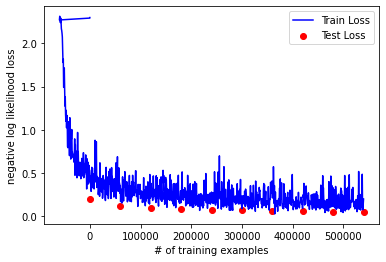

In [21]:
performance_plot = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.xlabel('# of training examples')
plt.ylabel('negative log likelihood loss')